# 라이브러리

In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
import random
import pingouin as pg

from sklearn.model_selection import train_test_split
from matplotlib.ticker import FuncFormatter
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm


# 한글 폰트 실행
from matplotlib import rcParams
from matplotlib import font_manager,rc
rcParams['axes.unicode_minus']=False
plt.rcParams['font.family']='NanumGothic'
font_name=font_manager.FontProperties(fname='c:/Windows/Fonts/NanumGothic.ttf').get_name()
rc('font',family=font_name)


# 사용자 정의 함수

## 데이터 용량 조절 함수

In [3]:
import pandas as pd 
import numpy as np

def reduce_mem_usage(df, float16_as32=True):
    # memory_usage()는 데이터프레임의 각 열의 메모리 사용량을 계산하고, sum은 그 값을 합산합니다. B -> KB -> MB로 변환합니다.
    start_mem = df.memory_usage().sum() / 1024**2
    print('데이터프레임의 초기 메모리 사용량은 {:.2f} MB입니다.'.format(start_mem))

    for col in df.columns:  # 각 열의 이름을 반복합니다.
        col_type = df[col].dtype  # 열의 데이터 타입을 가져옵니다.
        if col_type != object and str(col_type) != 'category':  # 객체 타입이 아닌 수치형 변수만 처리합니다.
            c_min, c_max = df[col].min(), df[col].max()  # 해당 열의 최소값과 최대값을 계산합니다.
            if str(col_type)[:3] == 'int':  # 정수형 변수일 경우 (int8, int16, int32, int64 모두 포함)
                # 이 열의 값 범위가 int8의 범위에 있을 경우 타입을 int8로 변환합니다. (-128부터 127까지)
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                # 이 열의 값 범위가 int16의 범위에 있을 경우 타입을 int16으로 변환합니다. (-32,768부터 32,767까지)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                # 이 열의 값 범위가 int32의 범위에 있을 경우 타입을 int32로 변환합니다. (-2,147,483,648부터 2,147,483,647까지)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                # 이 열의 값 범위가 int64의 범위에 있을 경우 타입을 int64로 변환합니다. (-9,223,372,036,854,775,808부터 9,223,372,036,854,775,807까지)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:  # 실수형일 경우
                # 값이 float16의 범위에 있을 경우 타입을 변환합니다. 더 높은 정밀도가 필요하면 float32를 고려합니다.
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32:  # 더 높은 정밀도가 필요하면 float32를 선택할 수 있습니다.
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16)
                # 값이 float32의 범위에 있을 경우 타입을 float32로 변환합니다.
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                # 값이 float64의 범위에 있을 경우 타입을 float64로 변환합니다.
                else:
                    df[col] = df[col].astype(np.float64)
    # 최종 메모리 사용량을 계산합니다.
    end_mem = df.memory_usage().sum() / 1024**2
    print('최적화 후 데이터프레임의 메모리 사용량은: {:.2f} MB입니다.'.format(end_mem))
    # 초기 메모리 사용량과 비교하여 몇 퍼센트 감소했는지 계산합니다.
    print('메모리 사용량이 {:.1f}% 감소했습니다.'.format(100 * (start_mem - end_mem) / start_mem))

    return df



import time

def execution_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Execution time for {func.__name__}: {int(hours)}h {int(minutes)}m {seconds:.2f}s")
        return result
    return wrapper



@execution_time
def clean_df(data):
    data['고객ID'] = data['고객ID'].astype(str)
    data = reduce_mem_usage(data)
    return data


## 분석도움함수

In [4]:
# 재분류
def rename_category_store(df):
    """
    가맹점 업종명을 지정된 카테고리로 재분류하는 함수입니다.

    이 함수는 입력된 데이터프레임의 '가맹점업종명' 열에 대해 특정 값들을 지정된 카테고리 이름으로
    대체하여 재분류합니다. 이를 통해 다양한 업종명이 지정된 범주의 카테고리로 통합됩니다.

    Parameters:
    df (pd.DataFrame): '가맹점업종명' 열을 포함한 데이터프레임.

    Returns:
    pd.DataFrame: '가맹점업종명' 열이 재분류된 데이터프레임.

    Example:
    >>> data = pd.DataFrame({
    ...     '가맹점업종명': ['보습학원', '피부미용실', '골프경기장', '주점', '약 국'],
    ...     '승인금액': [10000, 20000, 30000, 40000, 50000]
    ... })
    >>> rename_category_store(data)
    가맹점업종명 열을 다음과 같은 카테고리로 재분류합니다: ['교육/학원', '미용', '스포츠/레저', '외식', '의료/보험']
    
    """
    mapping = {
        '교육/학원': ['보습학원', '예·체능계학원', '외국어학원', '기타 교육기관', '기능학원', '학원', '학습지교육', '초중고교육기관'],
        '미용': ['미용원', '피부미용실'],
        '스포츠/레저': ['기타레져업소', '스포츠·레져용품', '스포츠의류', '스크린골프', '헬스클럽', '골프경기장', '종합레져타운', '골프용품 전문점', '골프연습장', '안마/스포츠마사지', '레져업소', '수 영 장'],
        '여행/교통': ['기타숙박업', '철도', '특급호텔', '1급 호텔', '렌터카', '항공사', '콘도', '2급 호텔', '관광여행', '여객선', '고속버스', '택시'],
        '외식': ['일반한식', '주점', '서양음식', '중국식', '일식·회집', '한정식', '칵테일바', '갈비전문점'],
        '대형마트': ['슈퍼마켓', '농협하나로클럽', '농,축협직영매장', '대형할인점'],
        '백화점': ['면 세 점', '자사카드발행백화점'],
        '편의점': ['편 의 점'],
        '음식료품': ['정육점', '스넥', '농·축·수산품', '농축수산가공품', '주류판매점', '홍삼제품', '인삼제품', '기타건강식품'],
        '카페/베이커리': ['기타음료식품', '제과점'],
        '의료/보험': ['약 국', '의 원', '한 의 원', '치과의원', '기타의료기관 및 기타의료기기', '한약방', '한방병원', '생명보험', '건강진단', '기타보험', '병 원(응급실운영)', '치과병원', '동물병원', '종합병원', '손해보험'],
        '주유': ['SK주유소', '쌍용S-OIL', 'GS주유소', '주유소', 'SK가스충전소', '현대정유(오일뱅크)', 'GS가스충전소', '쌍용S-OIL가스충전소', '현대정유가스충전소', 'E1가스충전소', '전기차충전소'],
        '문화생활': ['문화취미기타', '영화관', '티켓'],
        '이동통신요금': ['이동통신요금'],
        '반려동물': ['애완동물'],
        '간편결제': ['인터넷P/G'],
        '기타': ['전자상거래상품권전문판매', '캐주얼의류', 'CATV', '택시회사', '위성방송', '음반영상물', '제 화','주방용구', '연 쇄 점', '액세서리', '전문서적', '주차장', '민예·공예품', '건축용 요업제품', '단란주점', '옷감·직물', '자동차시트·타이어', '독서실', '농기계', '조명기구', '세차장', '사무서비스', '컴퓨터', '가 방', '보일러·펌프·샷시', '카페트,커튼,천막,지물', '자동차부품', '자동차정비', '기타유통업', '이륜차판매', '카인테리어', '화물운송', '내의판매', '목재·석재·철물', '기타 사무용품', '기타가구', '신 발', '비영리/비대상', '기타대인서비스', '기타전기제품', 'DP&E', '주방용식기', '가타자동차서비스', '기타농업관련', '구내매점(국가기관등)', '아동의류', '이용원', '조세서비스', '기념품점', '유흥주점', '통신기기', '화원', '화장품', '기타잡화', '유아원', 'LPG취급점', '페인트', '출판 및 인쇄물', '귀금속', '문구용품', '위탁급식업', '비료,사료,종자', '침구·수예점', '당구장', '가전제품', '인터넷Mall', '가정용품수리', '사무·통신기기수리', '안경', '세탁소', '사우나', '일반서적', '노 래 방', '기계공구',  '완구점', '기타의류', '미곡상', '기타용역서비스', '기타수리서비스', '기타건축자재', '일반가구', '사무용 OA기기', '인테리어전문', '가례서비스업', '시 계', '비영리/대상', '윤활유전문판매', '정수기', '공공요금대행서비스/소득공제비대상', '화방·표구점', '볼 링 장', '인터넷종합Mall', '기타 전문점', '통신판매업1', '종합용역', '전자상거래상품권', '보관및 창고업', '유류판매', '업종미등록', '통신서비스/소득공제비대상', '기타서적문구', '수족관', '공공요금대행서비스/소득공제대상', '상품권전문판매', '혼례서비스업', '냉열기기', '비씨카드 정산용(할인)', '일반(통신판매)', '기타4', '기타1', '부동산중개·임대', 'CATV홈쇼핑', '소프트웨어', '의료용품', '정장', '맞춤복점', '단체복', '상 품 권', 'PG상품권', '비씨카드 정산용가맹점',  '미용재료']
    }
    for category, values in mapping.items():
        df['가맹점업종명'] = df['가맹점업종명'].replace(values, category)
    print(df['가맹점업종명'].unique())
    return df

def rename_category_store_5(df):
    """
    가맹점 업종명을 미리 정의된 카테고리로 분류하여 새로운 '분류' 컬럼에 추가하는 함수입니다.

    이 함수는 입력된 데이터프레임의 '가맹점업종명' 열의 값들을 사전 정의된 카테고리로 매핑하여,
    각 가맹점이 해당하는 카테고리 정보를 새로운 '분류' 컬럼에 추가합니다. 이를 통해 다양한 업종을
    지정된 범주의 카테고리로 분류하여 분석할 수 있습니다.

    Parameters:
    df (pd.DataFrame): '가맹점업종명' 열을 포함한 데이터프레임.

    Returns:
    pd.DataFrame: '분류' 열이 추가된 데이터프레임.

    Example:
    >>> data = pd.DataFrame({
    ...     '가맹점업종명': ['백화점', '피부미용실', '골프경기장', '주점', '약국'],
    ...     '승인금액': [10000, 20000, 30000, 40000, 50000]
    ... })
    >>> rename_category_store_5(data)
    가맹점업종명 열을 다음과 같은 카테고리로 재분류합니다: ['쇼핑', '기타', '여가', '기타', '식음료']
    
    Categories:
      - 생활비: ['이동통신요금', '의료/보험', '교육/학원', '반려동물', '주유', '미용']
      - 식음료: ['외식', '카페/베이커리', '음식료품']
      - 쇼핑: ['백화점', '홈쇼핑', '온라인쇼핑', '간편결제', '편의점', '대형마트']
      - 여가: ['스포츠/레저', '여행/교통', '문화생활']
      - 기타: ['기타']
    
    """
    
    mapping = {
       '생활비' : ['이동통신요금', '의료/보험' , '교육/학원', '반려동물', '주유', '미용'],
        '식음료' : ['외식', '카페/베이커리', '음식료품'],
        '쇼핑' : ['백화점', '홈쇼핑', '온라인쇼핑', '간편결제', '편의점', '대형마트'],
        '여가' : ['스포츠/레저', '여행/교통', '문화생활'],
        '기타' : ['기타']
    }
 
    df['분류'] = df['가맹점업종명']
    for category, values in mapping.items():
        df.loc[df['가맹점업종명'].isin(values), '분류'] = category

    print(df['분류'].unique())
    return df


def rename_category_region(df):
    """
    가맹점 위치의 광역시도를 지정된 지역권으로 재분류하는 함수입니다.

    이 함수는 데이터프레임의 '가맹점_광역시도' 열에 대해 지역별 분류를 수행하여,
    수도권, 영남권, 충청권, 호남권, 강원·제주권으로 대체합니다.

    Parameters:
    df (pd.DataFrame): '가맹점_광역시도' 열을 포함한 데이터프레임.

    Returns:
    pd.DataFrame: '가맹점_광역시도' 열이 지역권으로 재분류된 데이터프레임.

    Example:
    >>> data = pd.DataFrame({
    ...     '가맹점_광역시도': ['서울특별시', '부산광역시', '제주특별자치도', '경기도', '대전광역시'],
    ...     '승인금액': [10000, 20000, 15000, 5000, 3000]
    ... })
    >>> rename_category_region(data)
    '가맹점_광역시도' 열을 다음과 같이 재분류합니다: 수도권, 영남권, 강원·제주권, 충청권 등.
    """
    region_groups = {
        '서울특별시': '수도권', '경기도': '수도권', '인천광역시': '수도권',
        '부산광역시': '영남권', '울산광역시': '영남권', '경상남도': '영남권',
        '충청북도': '충청권', '충청남도': '충청권', '대전광역시': '충청권', '세종특별자치시': '충청권',
        '전북특별자치도': '호남권', '전라남도': '호남권', '광주광역시': '호남권',
        '강원특별자치도': '강원·제주권', '제주특별자치도': '강원·제주권'
    }

    df['가맹점_광역시도'] = df['가맹점_광역시도'].replace(region_groups)
    df['가맹점_광역시도'].value_counts()
    return df

def join(df1, df2, key, way):
    """
    두 데이터프레임을 지정된 키와 조인 방식에 따라 병합하는 함수입니다.

    이 함수는 `pd.merge`를 사용하여 두 데이터프레임을 특정 열(`key`)을 기준으로 
    주어진 조인 방식(`way`)에 따라 병합합니다. 병합 결과는 데이터프레임 형식으로 반환됩니다.

    Parameters:
    df1 (pd.DataFrame): 첫 번째 데이터프레임.
    df2 (pd.DataFrame): 두 번째 데이터프레임.
    key (str): 조인할 때 사용할 공통 열의 이름.
    way (str): 조인 방식 (예: 'inner', 'left', 'right', 'outer').

    Returns:
    pd.DataFrame: 지정된 키와 방식으로 병합된 데이터프레임.

    Example:
    >>> df1 = pd.DataFrame({'ID': [1, 2, 3], 'Value1': ['A', 'B', 'C']})
    >>> df2 = pd.DataFrame({'ID': [2, 3, 4], 'Value2': ['X', 'Y', 'Z']})
    >>> join(df1, df2, key='ID', way='inner')
    <class 'pandas.core.frame.DataFrame'>
       ID Value1 Value2
    0   2      B      X
    1   3      C      Y
    """
    df_joined = pd.merge(df1, df2, on=f'{key}', how=f'{way}')
    print(type(df_joined))
    print(df_joined.head(3))
    return df_joined


## 시각화 함수

In [5]:
def barplot_sum(df, feature1, feature2, year, generation):
    """
    특정 기준(feature1)에 따라 그룹화하여 합계 값(feature2)을 계산하고, 이를 막대그래프로 시각화하는 함수.

    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임.
    feature1 : str
        그룹화를 위한 열 이름 (예: 업종명, 지역명 등).
    feature2 : str
        합계 계산의 대상이 되는 열 이름 (예: 승인 금액 등).
    year : int or str
        분석 대상 연도 (그래프 제목에 포함됨).
    generation : str
        분석 대상 세대 또는 분류 (그래프 제목에 포함됨).

    Returns
    -------
    None
        이 함수는 데이터를 시각화하여 출력하며 값을 반환하지 않습니다.

    Description
    -----------
    - 주어진 데이터프레임에서 feature1을 기준으로 feature2의 합계를 계산합니다.
    - 계산된 합계 값에 따라 막대그래프를 그립니다.
    - Y축은 feature2의 값을 '조 원' 단위로 변환하여 표시합니다.
    - 막대 위에 각 값(조 단위)을 표시하여 시각적으로 데이터를 쉽게 해석할 수 있도록 돕습니다.

    Example
    -------
    >>> import pandas as pd
    >>> import seaborn as sns
    >>> import matplotlib.pyplot as plt
    >>> data = {'업종': ['식당', '카페', '마트', '카페', '식당', '마트', '마트'],
                '승인금액': [1e12, 1.5e12, 2e12, 3e12, 2e12, 2.5e12, 5e12]}
    >>> df = pd.DataFrame(data)
    >>> barplot_sum(df, '업종', '승인금액', 2024, '40대')

    Output:
    - 2024년도 40대 업종별 승인금액 합계에 대한 막대그래프를 표시합니다.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    total_amounts = df.groupby([feature1])[feature2].sum().reset_index()
    total_amounts_sort = total_amounts.sort_values(by=feature2, ascending=False)
    ax = sns.barplot(x=f'{feature1}', y=f'{feature2}', data=total_amounts_sort, palette="viridis")
    ax.set_title(f"{year}년도 {generation} {feature1}별 {feature2} 합계")
    ax.set_xlabel(f"{feature1}")
    ax.set_ylabel(f"{feature2} 합계")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # x 위치 (막대 중앙)
            p.get_height() + 0.5,           # y 위치 (막대 위)
            f'{p.get_height() / 1e12:.2f}조',  # 조 단위로 변환 후 소수점 2자리까지 표시
            ha='center',                    # 텍스트 가운데 정렬
            fontsize=8
        )
    ax.text(1, 1.02, "(단위: 조 원)", ha='right', va='center', transform=ax.transAxes, fontsize=10, color="black")
    plt.show()


### 평균승인금액 출력 함수

In [6]:
def table_avg(df, feature1, feature2):
    """
    두 변수(feature1, feature2)를 기준으로 그룹화하여 평균 승인금액을 계산하는 함수.
    
    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임.
    feature1 : str
        그룹화를 위한 열 이름 (예: 고객 ID, 상품명 등).
    feature2 : str
        합계를 계산하고 평균을 산출할 열 이름 (예: 승인 금액 등).
    
    Returns
    -------
    pandas.DataFrame
        - feature1 : 그룹화된 고유 값.
        - feature2 : feature2의 합계 값.
        - 카드거래량 : 각 그룹에서 feature1의 발생 빈도.
        - 평균 승인금액 : feature2의 합계 값(feature2) / feature1의 빈도(카드거래량).
        
    Example
    -------
    >>> import pandas as pd
    >>> data = {'고객ID': ['A', 'A', 'B', 'B', 'B', 'C'],
                '승인금액': [100, 200, 300, 400, 500, 600]}
    >>> df = pd.DataFrame(data)
    >>> result = table_avg(df, '고객ID', '승인금액')
    >>> print(result)
       고객ID  승인금액  카드거래량    평균 승인금액
    0    A   300    2      150.0
    1    B  1200    3      400.0
    2    C   600    1      600.0
    """
    amounts = df.groupby([feature1])[feature2].sum().reset_index()
    counts = df[feature1].value_counts()
    amounts['카드거래량'] = amounts[feature1].map(counts).astype(float)  # 숫자형으로 변환
    amounts['평균 승인금액'] = amounts[feature2] / amounts['카드거래량']  # 평균 승인금액 계산
    
    #print(amounts[[feature1, feature2, '카드거래량', '평균 승인금액']])
    return amounts


In [7]:
def barplot_avg(df, feature1, feature2, year, generation):
    """
    특정 기준(feature1)에 따라 그룹화하여 평균 값(feature2)을 계산하고, 이를 막대그래프로 시각화하는 함수.

    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임.
    feature1 : str
        그룹화를 위한 열 이름 (예: 업종명, 지역명 등).
    feature2 : str
        합계 및 평균 계산의 대상이 되는 열 이름 (예: 승인 금액 등).
    year : int or str
        분석 대상 연도 (그래프 제목에 포함됨).
    generation : str
        분석 대상 세대 또는 분류 (그래프 제목에 포함됨).
    
    Returns
    -------
    None
        이 함수는 데이터를 시각화하여 출력하며 값을 반환하지 않습니다.
    
    Description
    -----------
    - 주어진 데이터프레임에서 feature1을 기준으로 feature2의 합계와 평균을 계산합니다.
    - 계산된 평균 값에 따라 막대그래프를 그립니다.
    - Y축은 평균 승인금액을 '만 원' 단위로 변환하여 표시합니다.
    - 막대 위에 각 값(만원 단위)을 표시하여 시각적으로 데이터를 쉽게 해석할 수 있도록 돕습니다.

    Example
    -------
    >>> import pandas as pd
    >>> import seaborn as sns
    >>> import matplotlib.pyplot as plt
    >>> data = {'업종': ['식당', '카페', '마트', '카페', '식당', '마트', '마트'],
                '승인금액': [10000, 15000, 20000, 30000, 20000, 25000, 50000]}
    >>> df = pd.DataFrame(data)
    >>> barplot_avg(df, '업종', '승인금액', 2024, '40대')
    
    Output:
    - 2024년도 40대 업종별 평균 승인금액에 대한 막대그래프를 표시합니다.
    """
    amounts = df.groupby([feature1])[feature2].sum().reset_index()
    counts = df[feature1].value_counts()
    amounts['카드거래량'] = amounts[feature1].map(counts).astype(float)  # 숫자형으로 변환
    amounts['평균 승인금액'] = amounts[feature2] / amounts['카드거래량']  # 평균 승인금액 계산
    amounts_sort = amounts.sort_values(by='평균 승인금액', ascending=False)
    amounts_sort['평균 승인금액_만단위'] = amounts_sort['평균 승인금액']

    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(x=f'{feature1}', y='평균 승인금액', data=amounts_sort, palette="viridis")
    ax.set_title(f"{year}년도 {generation} {feature1}별 평균{feature2}")
    ax.set_xlabel(f"{feature1}")
    ax.set_ylabel("평균 승인금액 (단위: 만 원)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ticks = ax.get_yticks()  # 현재 Y축 눈금 가져오기
    ax.set_yticklabels([int(tick / 10000) for tick in ticks])  # 만 단위로 변환하여 설정
    
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # x 위치 (막대 중앙)
            p.get_height() + 0.5,           # y 위치 (막대 위)
            f'{p.get_height() / 10000:.2f}만원',  # 만 단위로 표시
            ha='center',                    # 텍스트 가운데 정렬
            fontsize=6
        )

    ax.text(1, 1.02, "(단위: 만 원)", ha='right', va='center', transform=ax.transAxes, fontsize=10, color="black")
    
    plt.show()


### 인당 평균승인금액표 출력 함수

In [41]:
def table_avg_2(df, feature1, feature2, target, generation):
    """
    특정 기준(feature1, feature2)에 따라 target 값의 합계를 계산하고,
    feature2 기준으로 그룹화하여 세대 정보를 추가한 데이터프레임을 반환하는 함수.

    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임.
    feature1 : str
        1차 그룹화를 위한 열 이름 (예: 고객 ID 등).
    feature2 : str
        2차 그룹화를 위한 열 이름 (예: 업종명 등).
    target : str
        합계를 계산할 대상 열 이름 (예: 승인 금액 등).
    generation : str
        세대를 나타내는 문자열 (예: '40대', '50대' 등).

    Returns
    -------
    pandas.DataFrame
        - feature2 : 그룹화 기준 열.
        - target : feature2 기준 target 값의 합계.
        - 연령대 : 세대를 나타내는 열.

    Description
    -----------
    - feature1과 feature2를 기준으로 target 값의 합계를 계산합니다.
    - feature2 기준으로 다시 그룹화하여 target 값의 총합을 구합니다.
    - 계산된 데이터는 target 값을 기준으로 내림차순 정렬됩니다.
    - generation 값을 '연령대' 열에 추가하여 반환합니다.

    Example
    -------
    >>> import pandas as pd
    >>> data = {'고객ID': ['A', 'A', 'B', 'B', 'C', 'C', 'C'],
                '업종명': ['식당', '카페', '마트', '식당', '카페', '마트', '마트'],
                '승인금액': [100, 200, 300, 400, 500, 600, 700]}
    >>> df = pd.DataFrame(data)
    >>> result = table_avg_2(df, '고객ID', '업종명', '승인금액', '40대')
    >>> print(result)
        업종명  승인금액   연령대
    2    마트  1600   40대
    1    카페   700   40대
    0    식당   500   40대
    """
    sum_df = df.groupby([feature1, feature2])[target].sum().reset_index()
    mean_df = sum_df.groupby(feature2)[target].sum().reset_index()
    mean_df = mean_df.sort_values(by=target, ascending=False)
    mean_df['연령대'] = generation
    return mean_df


### 인당 평균승인금액 bar plot 출력 함수

In [9]:
def barplot_avg_2(df, feature1, target, year, generation):
    """
    특정 기준(feature1)에 따라 target 값을 평균 단위로 변환한 뒤, 이를 막대그래프로 시각화하는 함수.

    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임.
    feature1 : str
        그룹화를 위한 열 이름 (예: 업종명, 지역명 등).
    target : str
        평균을 계산하고 시각화할 대상 열 이름 (예: 승인 금액 등).
    year : int or str
        분석 대상 연도 (그래프 제목에 포함됨).
    generation : str
        분석 대상 세대 또는 분류 (그래프 제목에 포함됨).

    Returns
    -------
    None
        이 함수는 데이터를 시각화하여 출력하며 값을 반환하지 않습니다.

    Description
    -----------
    - 주어진 데이터프레임에서 target 값을 '백만 원' 단위로 변환하여 시각화합니다.
    - feature1 기준으로 target 값의 평균을 계산하고, 이를 기반으로 막대그래프를 생성합니다.
    - Y축은 target 값을 '조 원' 단위로 변환하여 표시합니다.
    - 막대 위에는 각 값(조 단위)을 표시하여 데이터를 직관적으로 해석할 수 있도록 돕습니다.
    - 그래프의 제목과 축 레이블은 입력된 연도(year)와 세대(generation)를 반영합니다.

    Example
    -------
    >>> import pandas as pd
    >>> import seaborn as sns
    >>> import matplotlib.pyplot as plt
    >>> data = {'업종': ['식당', '카페', '마트', '식당', '카페', '마트', '마트'],
                '승인금액': [1e12, 1.5e12, 2e12, 3e12, 2e12, 2.5e12, 5e12]}
    >>> df = pd.DataFrame(data)
    >>> barplot_avg_2(df, '업종', '승인금액', 2024, '40대')

    Output:
    - 2024년도 40대 업종별 인당 평균 승인금액에 대한 막대그래프를 표시합니다.
    """
    df['승인금액_단위백'] = df[target] / 1e6
    fig, ax = plt.subplots(figsize = (10,6))
    ax = sns.barplot(x=f'{feature1}', y=f'{target}', data=df, palette="viridis")
    ax.set_title(f"{year}년도 {generation} 인당 {feature1}별 평균{target}")
    ax.set_xlabel(f"{feature1}")
    ax.set_ylabel(f"평균{target}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # x 위치 (막대 중앙)
            p.get_height() + 0.5,           # y 위치 (막대 위)
            f'{p.get_height() / 1e12:.2f}조',  # 조 단위로 변환 후 소수점 2자리까지 표시
            ha='center',                    # 텍스트 가운데 정렬
            fontsize=8
        )
    ax.text(1, 1.02, "(단위: 백만 원)", ha='right', va='center', transform=plt.gca().transAxes, fontsize=10, color="black")
    plt.show()

### 인당 평균승인금액 + bar plot 출력 함수

In [10]:
def table_avg_2(df, feature1, feature2, target, year, generation):
    """
    두 개의 그룹화 기준(feature1, feature2)을 활용하여 target 값의 합계와 평균을 계산하고,
    feature2 기준으로 시각화하는 함수.

    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임.
    feature1 : str
        1차 그룹화를 위한 열 이름 (예: 고객ID, 지역 등).
    feature2 : str
        2차 그룹화를 위한 열 이름 (예: 업종명, 상품명 등).
    target : str
        합계 및 평균을 계산할 대상 열 이름 (예: 승인 금액, 거래 횟수 등).
    year : int or str
        분석 대상 연도 (그래프 제목에 포함됨).
    generation : str
        분석 대상 세대 또는 분류 (그래프 제목에 포함됨).

    Returns
    -------
    None
        이 함수는 데이터를 시각화하여 출력하며 값을 반환하지 않습니다.

    Description
    -----------
    - 주어진 데이터프레임에서 feature1과 feature2를 기준으로 target 값의 합계를 계산합니다.
    - feature2 기준으로 target 값의 총합을 다시 계산하고 내림차순으로 정렬합니다.
    - 계산된 결과를 기반으로 막대그래프를 생성합니다.
    - Y축은 target 값을 '조 원' 단위로 변환하여 표시하며, 그래프 제목과 축 레이블에 입력된 연도(year)와 세대(generation)를 반영합니다.
    - 막대 위에 각 값(조 단위)을 표시하여 데이터를 직관적으로 해석할 수 있도록 돕습니다.

    Example
    -------
    >>> import pandas as pd
    >>> import seaborn as sns
    >>> import matplotlib.pyplot as plt
    >>> data = {'고객ID': ['A', 'A', 'B', 'B', 'C', 'C', 'C'],
                '업종명': ['식당', '카페', '마트', '식당', '카페', '마트', '마트'],
                '승인금액': [1e12, 1.5e12, 2e12, 3e12, 2e12, 2.5e12, 5e12]}
    >>> df = pd.DataFrame(data)
    >>> table_avg_2(df, '고객ID', '업종명', '승인금액', 2024, '40대')

    Output:
    - 2024년도 40대 업종별 인당 평균 승인금액에 대한 막대그래프를 표시합니다.
    """

    sum_df = df.groupby([feature1, feature2])[target].sum().reset_index()
    mean_df = sum_df.groupby(feature2)[target].sum().reset_index()
    mean_df = mean_df.sort_values(by=target, ascending=False)
    
    mean_df['승인금액_단위백'] = mean_df[target] / 1e6
    fig, ax = plt.subplots(figsize = (10,6))
    ax = sns.barplot(x=f'{feature2}', y=f'{target}', data=mean_df, palette="viridis")
    ax.set_title(f"{year}년도 {generation} 인당 {feature2}별 평균{target}")
    ax.set_xlabel(f"{feature2}")
    ax.set_ylabel(f"평균{target}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # x 위치 (막대 중앙)
            p.get_height() + 0.5,           # y 위치 (막대 위)
            f'{p.get_height() / 1e12:.2f}조',  # 조 단위로 변환 후 소수점 2자리까지 표시
            ha='center',                    # 텍스트 가운데 정렬
            fontsize=8
        )
    ax.text(1, 1.02, "(단위: 백만 원)", ha='right', va='center', transform=plt.gca().transAxes, fontsize=10, color="black")
    plt.show()
    return 


### 세대별 비교 barplot

In [70]:
def compare_generation_spending(df_40s, df_50s, df_60s, feature, target, year):
    """
    세대별 데이터프레임을 받아 특정 기준(feature)에 따라 target 값(승인금액)을 비교하는 그래프를 생성하는 함수.

    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    Parameters
    ----------
    df_40s : pandas.DataFrame
        40대 데이터프레임.
    df_50s : pandas.DataFrame
        50대 데이터프레임.
    df_60s : pandas.DataFrame
        60대 이상 데이터프레임.
    feature : str
        비교할 기준이 되는 열 (예: '가맹점업종명').
    target : str
        합계 및 비교 대상 열 (예: '승인금액').
    year : int or str
        분석 대상 연도 (그래프 제목에 포함됨).

    Returns
    -------
    None
        데이터를 시각화하여 출력하며 값을 반환하지 않습니다.
    """
    # 세대별 연령대 열 추가
    df_40s['연령대'] = '40대'
    df_50s['연령대'] = '50대'
    df_60s['연령대'] = '60대 이상'

    # 필요한 열 선택 및 데이터프레임 병합
    combined_data = pd.concat([
        df_40s[[feature, target, '연령대']],
        df_50s[[feature, target, '연령대']],
        df_60s[[feature, target, '연령대']]
    ])

    # 그룹화하여 업종별 승인금액 합계 계산
    age_group_summary = combined_data.groupby(['연령대', feature])[target].sum().reset_index()

    # 시각화
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(
        data=age_group_summary,
        x=feature,
        y=target,
        hue='연령대',
        palette="viridis"
    )
    ax.set_title(f"{year}년도 세대별 {feature} 카드 승인 금액 합계")
    ax.set_xlabel(feature)
    ax.set_ylabel("승인 금액")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.legend(title="연령대")
    plt.show()


### 박스플롯 그리는 함수 (그냥, 로그)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def boxplot_log(dataframes, category, target, feature, year=None, log=None):
    """
    특정 카테고리와 타겟 변수를 기준으로 고객 ID별 데이터에 대한 박스플롯을 생성하는 함수.
    기본적으로 로그 변환을 적용하며, log=False로 설정하면 로그 변환 없이 원본 데이터로 시각화함.

    Parameters:
    ----------
    dataframes : list of pd.DataFrame
        여러 연령대에 대한 데이터프레임 리스트. 각 데이터프레임은 '고객ID', category, target 열을 포함해야 함.
        
    category : str
        그룹화할 기준이 되는 열 이름 (예: '분류' 또는 '연령대').
        
    target : str
        분석할 변수의 열 이름 (예: '승인금액').
        
    feature : str
        특정 카테고리의 값을 지정하는 변수. 지정된 category 값 중 이 feature 값에 해당하는 데이터만 시각화.
        
    year : int, optional
        데이터의 연도를 나타내는 선택적 인수로, 제목에 표시됨. 기본값은 None.
        
    log : bool, optional, default=None
        로그 변환 여부를 설정하는 옵션. 기본값은 None으로, 이 경우 로그 변환을 적용합니다.
        log=False로 설정하면 로그 변환 없이 원본 데이터로 시각화합니다.

    Returns:
    -------
    None
        이 함수는 박스플롯을 생성하여 보여주며, 아무 값도 반환하지 않음.

    Example:
    -------
    # 로그 변환을 적용하여 박스플롯 생성 (기본 설정)
    plot_box_with_log([df_40s, df_50s, df_60s], category='분류', target='승인금액', feature='쇼핑')

    # 로그 변환 없이 박스플롯 생성
    plot_box_with_log([df_40s, df_50s, df_60s], category='분류', target='승인금액', feature='쇼핑', log=False)
    """
    data = []
    
    for df in dataframes:
        df_group = df.groupby(['고객ID', category])[target].sum().reset_index()
        
        # log 옵션에 따라 로그 변환 여부 결정
        if log is None or log:  # log가 None이거나 True일 경우 로그 변환 적용
            data.append(np.log1p(df_group[df_group[category] == feature][target]))
        else:  # log=False일 경우 원본 데이터 사용
            data.append(df_group[df_group[category] == feature][target])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.boxplot(data, labels=['40대', '50대', '60대'])
    
    # 제목에 로그 변환 여부 추가
    title = f"{'로그 변환된 ' if log is None or log else ''}고객ID 당 분류 중 {feature}의 `{target}` 합계"
    if year is not None:
        title = f"{'로그 변환된 ' if log is None or log else ''}{year}년도 고객ID 당 분류 중 {feature}의 `{target}` 합계"
    
    ax.set_title(title)
    ax.set_xlabel('연령대')
    ax.set_ylabel('승인금액' + (' (로그 스케일)' if log is None or log else ''))
    plt.show()
    return

# 데이터 불러오기

In [12]:
import pandas as pd
DATA_PATH = './dataset/CARD/'
DATA_PATH_2 = './dataset/CUSTOMER/'
DATA_PATH_3 = './dataset/CC/'

In [13]:
cc_23_40_r = pd.read_csv(DATA_PATH_3 + 'cc_23_40_r.csv', encoding="utf-8-sig")
cc_23_50_r = pd.read_csv(DATA_PATH_3 + 'cc_23_50_r.csv', encoding="utf-8-sig")
cc_23_60_r = pd.read_csv(DATA_PATH_3 + 'cc_23_60_r.csv', encoding="utf-8-sig")

# 데이터 확인

In [14]:
cc_23_40_r.head()

,고객ID,거래년월,가맹점업종명,가맹점_광역시도,가맹점_시군구,승인건수,승인금액
0,9997288918,202312,기타,서울특별시,중구,5번이하,9483
1,9997288918,202312,대형마트,경상북도,경산시,5번이하,31139
2,9997288918,202312,음식료품,경상남도,김해시,5번이하,31013
3,9997288918,202312,편의점,경상북도,김천시,5번이하,32098
4,9997288918,202312,외식,경상북도,김천시,5번이하,20945


In [15]:
cc_23_50_r.head()

,고객ID,거래년월,가맹점업종명,가맹점_광역시도,가맹점_시군구,승인건수,승인금액
0,9998361242,202312,외식,경상북도,칠곡군,5번이하,30594
1,9998361242,202312,외식,경상북도,구미시,5번이하,111553
2,9998361242,202311,외식,경상북도,구미시,5번이하,40059
3,9998361242,202311,대형마트,경상북도,구미시,5번이하,9242
4,9998361242,202311,의료/보험,경상북도,구미시,5번이하,22743


In [16]:
cc_23_60_r.head()

,고객ID,거래년월,가맹점업종명,가맹점_광역시도,가맹점_시군구,승인건수,승인금액
0,9999998161,202311,대형마트,대구광역시,중구,5번이하,18604
1,9999998161,202311,외식,대구광역시,중구,5번이하,61930
2,9999998161,202303,대형마트,대구광역시,중구,5번이하,22079
3,9999918728,202310,대형마트,대구광역시,북구,5번이하,40587
4,9999918728,202308,대형마트,대구광역시,북구,5번이하,39788


In [17]:
cc_23_40_r = rename_category_store_5(cc_23_40_r)
cc_23_40_r.head()

['기타' '쇼핑' '식음료' '생활비' '여가']


,고객ID,거래년월,가맹점업종명,가맹점_광역시도,가맹점_시군구,승인건수,승인금액,분류
0,9997288918,202312,기타,서울특별시,중구,5번이하,9483,기타
1,9997288918,202312,대형마트,경상북도,경산시,5번이하,31139,쇼핑
2,9997288918,202312,음식료품,경상남도,김해시,5번이하,31013,식음료
3,9997288918,202312,편의점,경상북도,김천시,5번이하,32098,쇼핑
4,9997288918,202312,외식,경상북도,김천시,5번이하,20945,식음료


In [18]:
cc_23_50_r = rename_category_store_5(cc_23_50_r)
cc_23_50_r.head()

['식음료' '쇼핑' '생활비' '여가' '기타']


,고객ID,거래년월,가맹점업종명,가맹점_광역시도,가맹점_시군구,승인건수,승인금액,분류
0,9998361242,202312,외식,경상북도,칠곡군,5번이하,30594,식음료
1,9998361242,202312,외식,경상북도,구미시,5번이하,111553,식음료
2,9998361242,202311,외식,경상북도,구미시,5번이하,40059,식음료
3,9998361242,202311,대형마트,경상북도,구미시,5번이하,9242,쇼핑
4,9998361242,202311,의료/보험,경상북도,구미시,5번이하,22743,생활비


In [19]:
cc_23_60_r = rename_category_store_5(cc_23_60_r)
cc_23_60_r.head()

['쇼핑' '식음료' '생활비' '기타' '여가']


,고객ID,거래년월,가맹점업종명,가맹점_광역시도,가맹점_시군구,승인건수,승인금액,분류
0,9999998161,202311,대형마트,대구광역시,중구,5번이하,18604,쇼핑
1,9999998161,202311,외식,대구광역시,중구,5번이하,61930,식음료
2,9999998161,202303,대형마트,대구광역시,중구,5번이하,22079,쇼핑
3,9999918728,202310,대형마트,대구광역시,북구,5번이하,40587,쇼핑
4,9999918728,202308,대형마트,대구광역시,북구,5번이하,39788,쇼핑


# EDA 1 : 승인금액 합계 barplot
## 가맹점업종명(중분류 별)

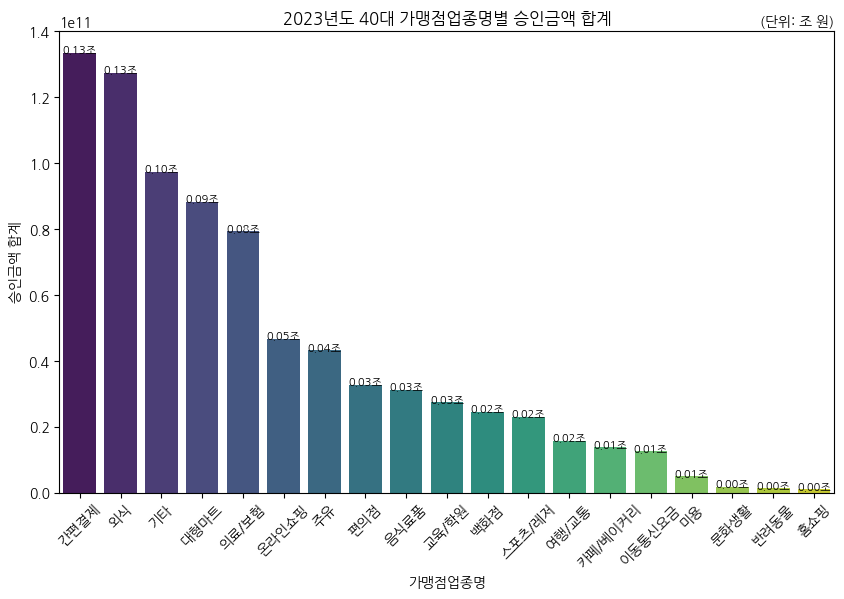

In [20]:
barplot_sum(cc_23_40_r, "가맹점업종명", "승인금액", "2023", "40대")

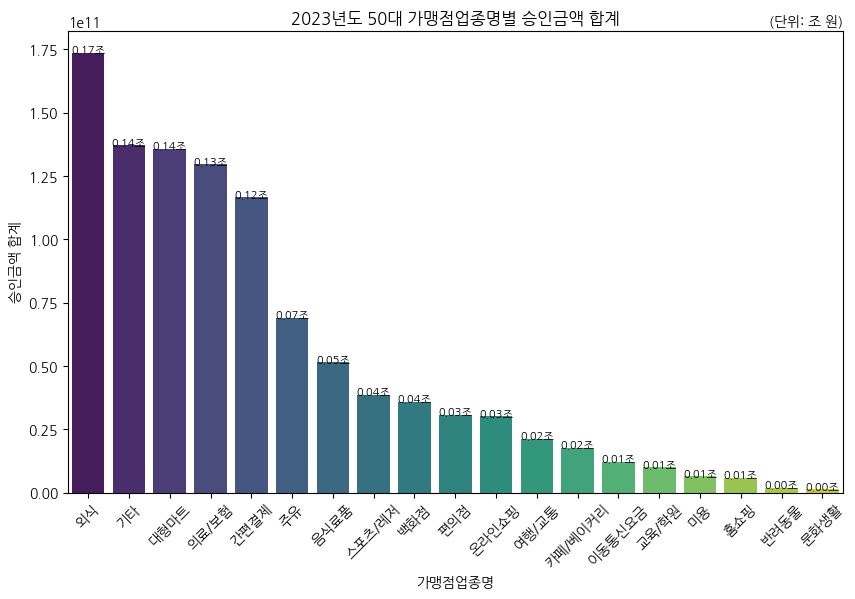

In [21]:
barplot_sum(cc_23_50_r, "가맹점업종명", "승인금액", "2023", "50대")

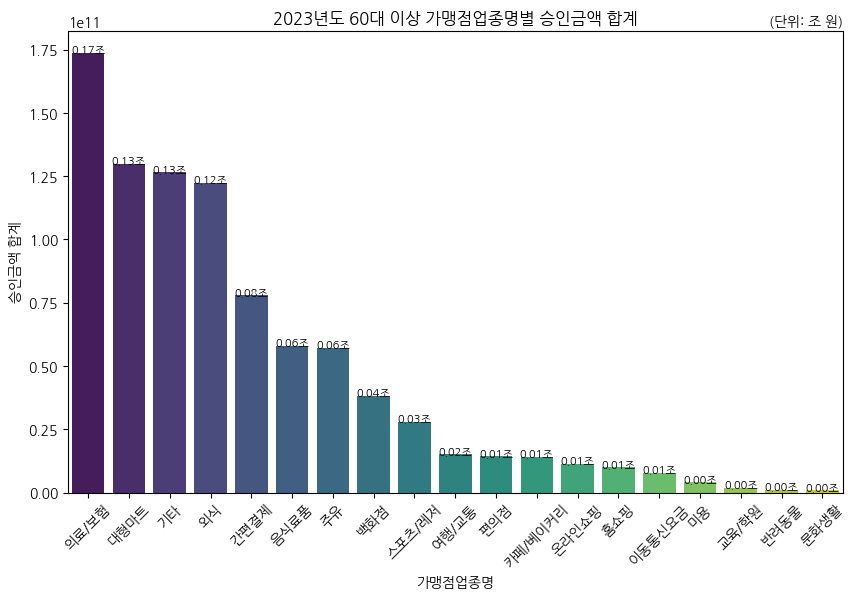

In [22]:
barplot_sum(cc_23_60_r, "가맹점업종명", "승인금액", "2023", "60대 이상")

## 대분류별

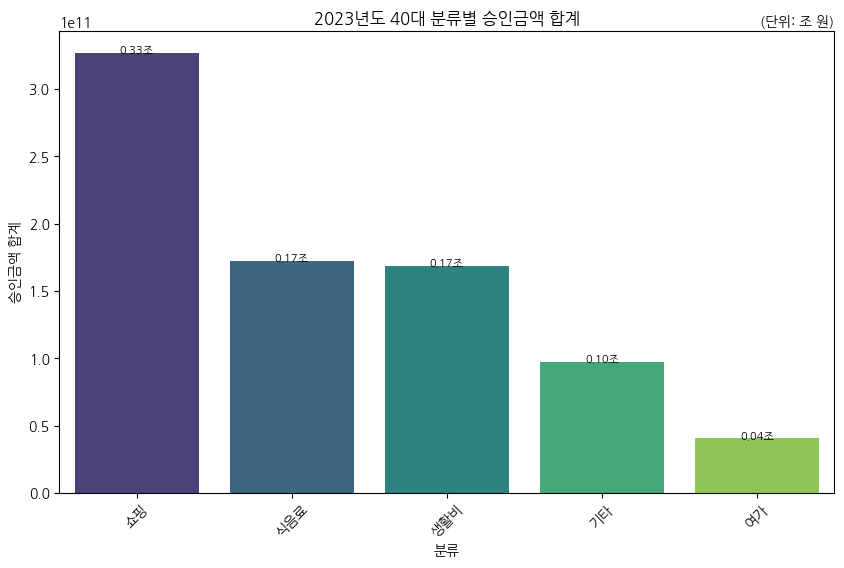

In [23]:
barplot_sum(cc_23_40_r, "분류", "승인금액", "2023", "40대")

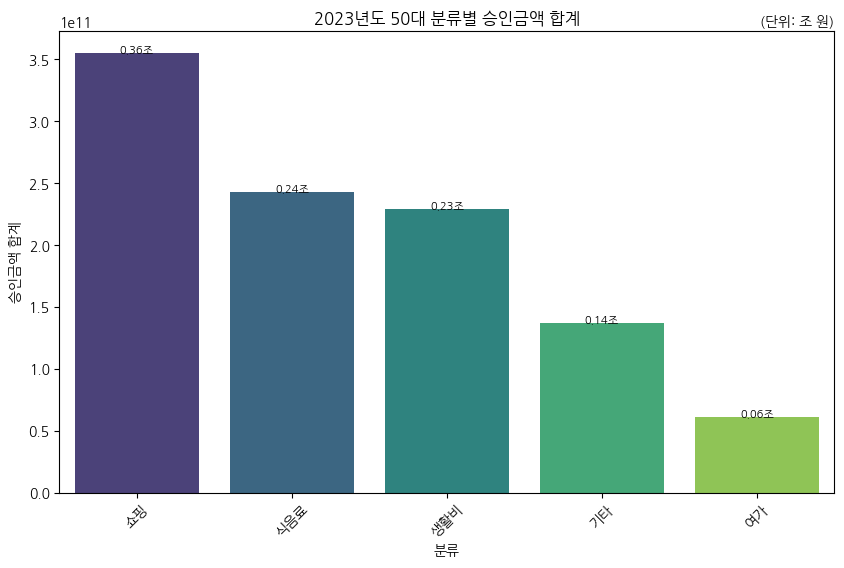

In [24]:
barplot_sum(cc_23_50_r, "분류", "승인금액", "2023", "50대")

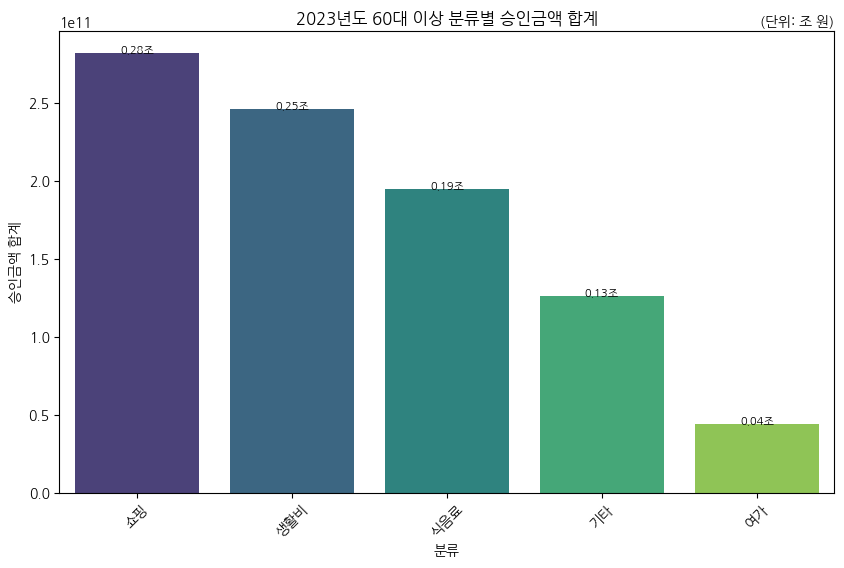

In [25]:
barplot_sum(cc_23_60_r, "분류", "승인금액", "2023", "60대 이상")

# EDA 2 가맹점업종명별 평균승인금액 barplot

## 가맹점업종명별 평균승인금액 표

In [26]:
table_avg(cc_23_40_r, "가맹점업종명", "승인금액")

,가맹점업종명,승인금액,카드거래량,평균 승인금액
0,간편결제,133520830053,1361982.0,98034.210476
1,교육/학원,27442057371,112704.0,243487.874175
2,기타,97392240760,1323996.0,73559.316463
3,대형마트,88245726884,1490964.0,59187.027241
4,문화생활,1747492878,63444.0,27543.863533
5,미용,5017474180,122493.0,40961.313544
6,반려동물,1282363514,25913.0,49487.265620
7,백화점,24570247926,160793.0,152806.701324
8,스포츠/레저,23041953728,247630.0,93049.928232
9,여행/교통,15826303760,354636.0,44626.895634


In [27]:
table_avg(cc_23_50_r, "가맹점업종명", "승인금액")

,가맹점업종명,승인금액,카드거래량,평균 승인금액
0,간편결제,116552543557,1045099.0,111522.969170
1,교육/학원,10113503302,33581.0,301167.425092
2,기타,137165356834,1849565.0,74160.873954
3,대형마트,135874421338,2198552.0,61801.777414
4,문화생활,1414081783,51189.0,27624.719823
5,미용,6595085644,155255.0,42479.054742
6,반려동물,1900484794,38164.0,49797.840740
7,백화점,35873485652,204832.0,175136.139138
8,스포츠/레저,38668671941,337261.0,114655.035539
9,여행/교통,21345122395,484430.0,44062.346252


In [28]:
table_avg(cc_23_60_r, "가맹점업종명", "승인금액")

,가맹점업종명,승인금액,카드거래량,평균 승인금액
0,간편결제,78070281450,649284.0,120240.574926
1,교육/학원,1999699719,7606.0,262910.822903
2,기타,126553931685,1794311.0,70530.655881
3,대형마트,129820716435,2166642.0,59917.935882
4,문화생활,894916672,26309.0,34015.609563
5,미용,4203350741,98252.0,42781.324970
6,반려동물,1171395725,24066.0,48674.300881
7,백화점,38308251620,213382.0,179528.974421
8,스포츠/레저,28075561707,221055.0,127007.132646
9,여행/교통,15260588146,355846.0,42885.372172


## 가맹점업종명별 평균승인금액 bar plot

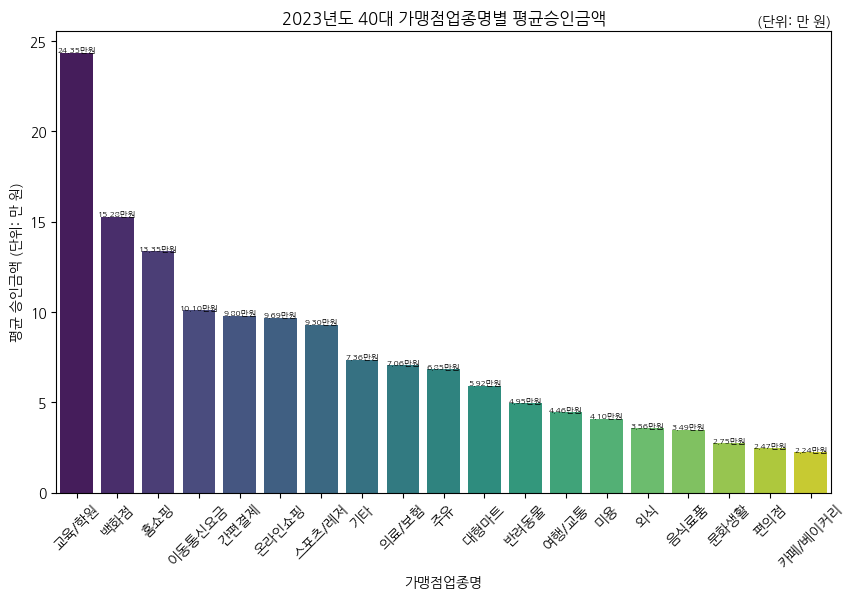

In [29]:
barplot_avg(cc_23_40_r, "가맹점업종명", "승인금액", "2023", "40대")

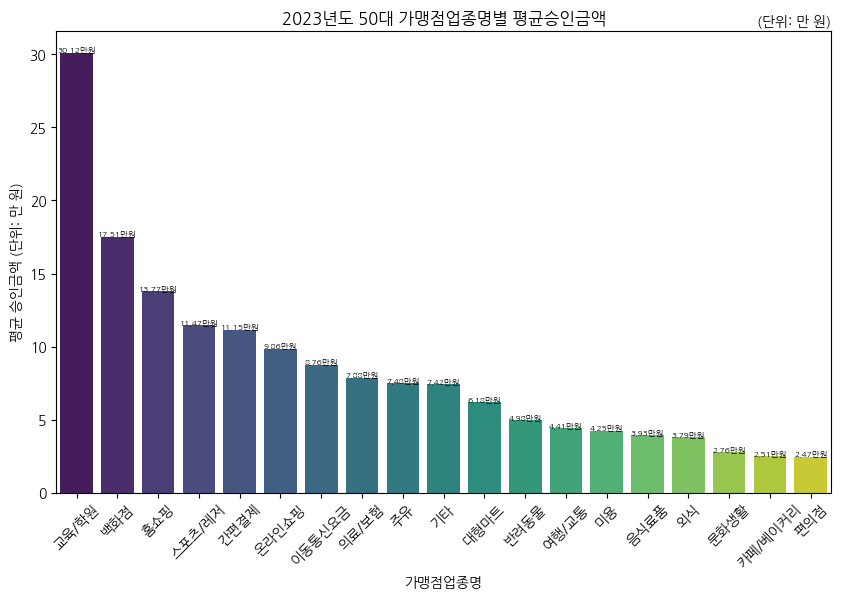

In [30]:
barplot_avg(cc_23_50_r, "가맹점업종명", "승인금액", "2023", "50대")

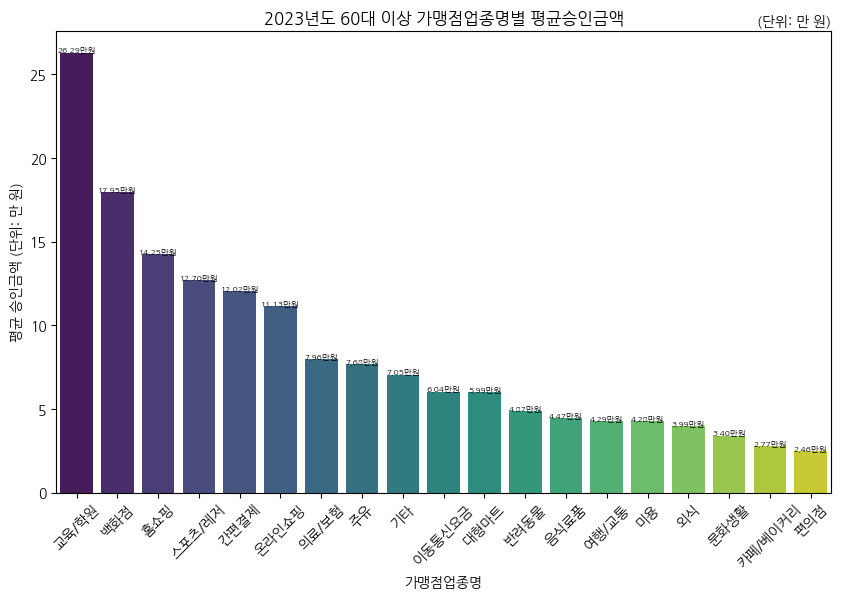

In [31]:
barplot_avg(cc_23_60_r, "가맹점업종명", "승인금액", "2023", "60대 이상")

## 대분류별 평균승인금액 bar plot

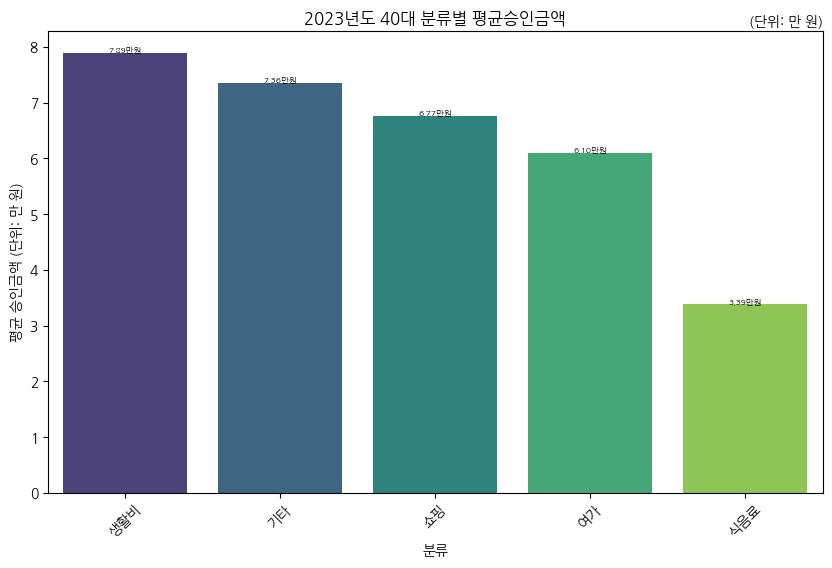

In [32]:
barplot_avg(cc_23_40_r, "분류", "승인금액", "2023", "40대")

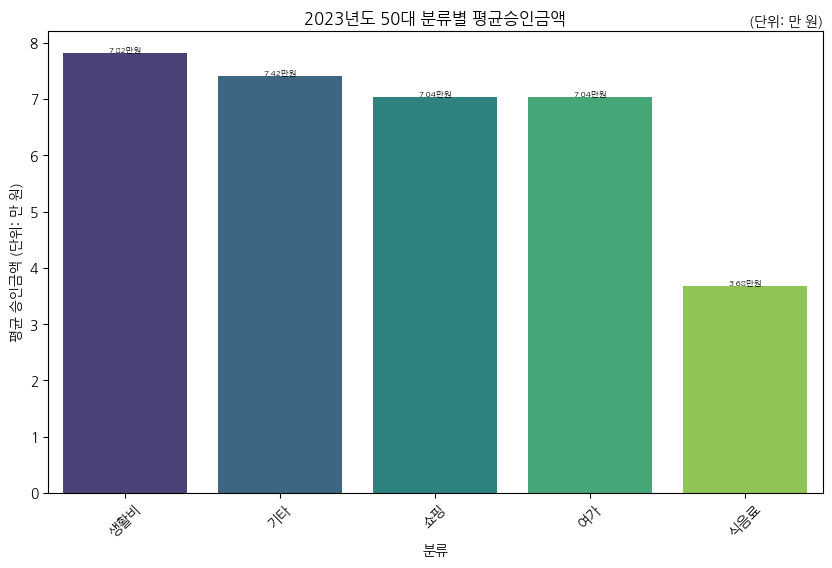

In [33]:
barplot_avg(cc_23_50_r, "분류", "승인금액", "2023", "50대")

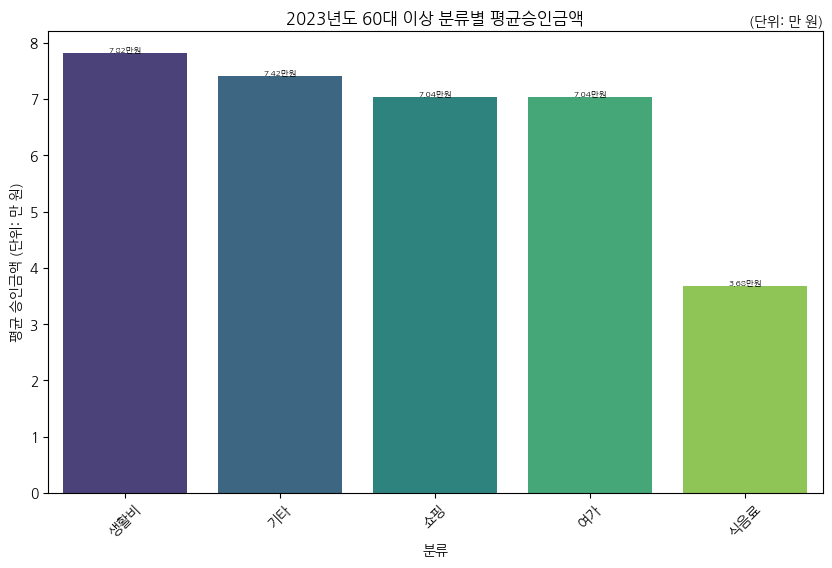

In [34]:
barplot_avg(cc_23_50_r, "분류", "승인금액", "2023", "60대 이상")

# EDA 3 인당 평균승인금액 barplot

## 가맹점업종명(중분류별)

### (1) 인당 평균승인금액 표

In [37]:
cc_23_40_g = table_avg_2(cc_23_40_r, "고객ID", "가맹점업종명", "승인금액", "40대")
cc_23_40_g.head()

,가맹점업종명,승인금액,연령대
0,간편결제,133520830053,40대
11,외식,127378773727,40대
2,기타,97392240760,40대
3,대형마트,88245726884,40대
13,의료/보험,79280381496,40대


In [38]:
cc_23_50_g = table_avg_2(cc_23_50_r, "고객ID", "가맹점업종명", "승인금액", "50대")
cc_23_50_g.head()

,가맹점업종명,승인금액,연령대
11,외식,173712891651,50대
2,기타,137165356834,50대
3,대형마트,135874421338,50대
13,의료/보험,129623585651,50대
0,간편결제,116552543557,50대


In [40]:
cc_23_60_g = table_avg_2(cc_23_60_r, "고객ID", "가맹점업종명", "승인금액", "60대 이상")
cc_23_60_g.head()

,가맹점업종명,승인금액,연령대
13,의료/보험,173770593820,60대 이상
3,대형마트,129820716435,60대 이상
2,기타,126553931685,60대 이상
11,외식,122489972940,60대 이상
0,간편결제,78070281450,60대 이상


### (2) 인당 평균승인금액 bar plot

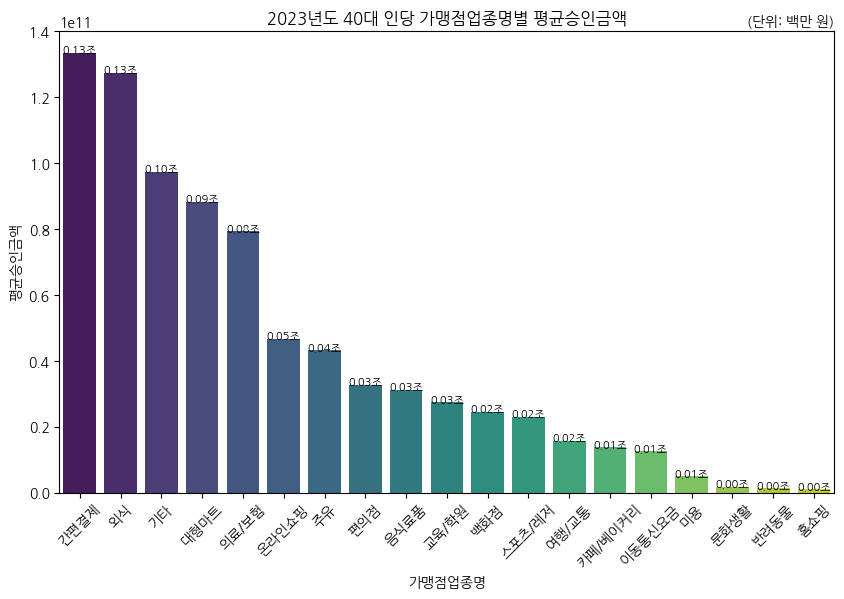

In [80]:
barplot_avg_2(cc_23_40_g, "가맹점업종명", "승인금액", "2023", "40대")

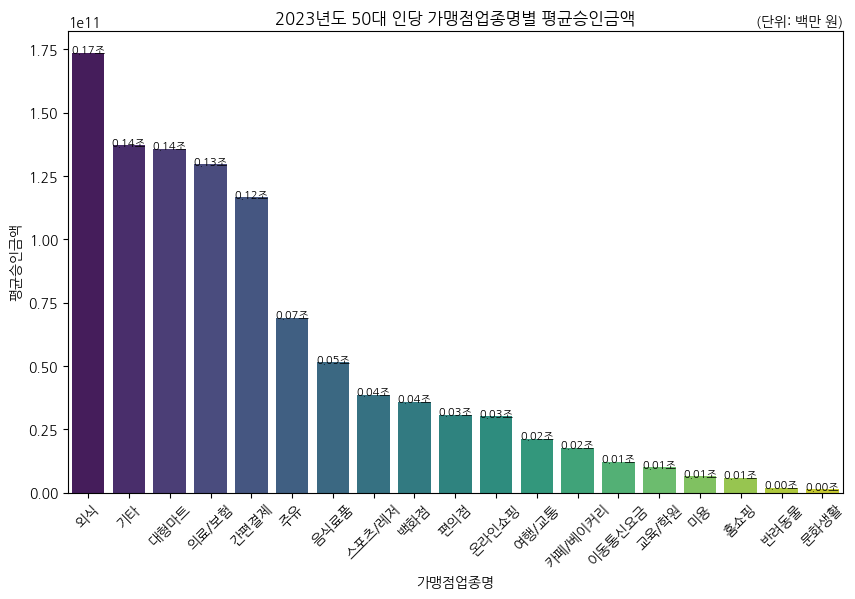

In [83]:
barplot_avg_2(cc_23_50_g, "가맹점업종명", "승인금액", "2023", "50대")

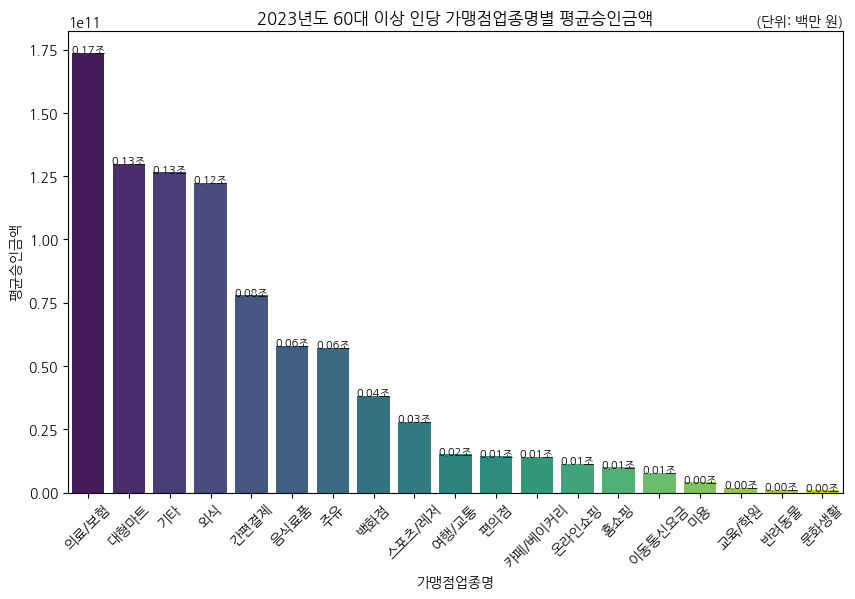

In [86]:
barplot_avg_2(cc_23_60_g, "가맹점업종명", "승인금액", "2023", "60대 이상")

### (3) 인당 평균승인금액 계산 + barplot 한번에

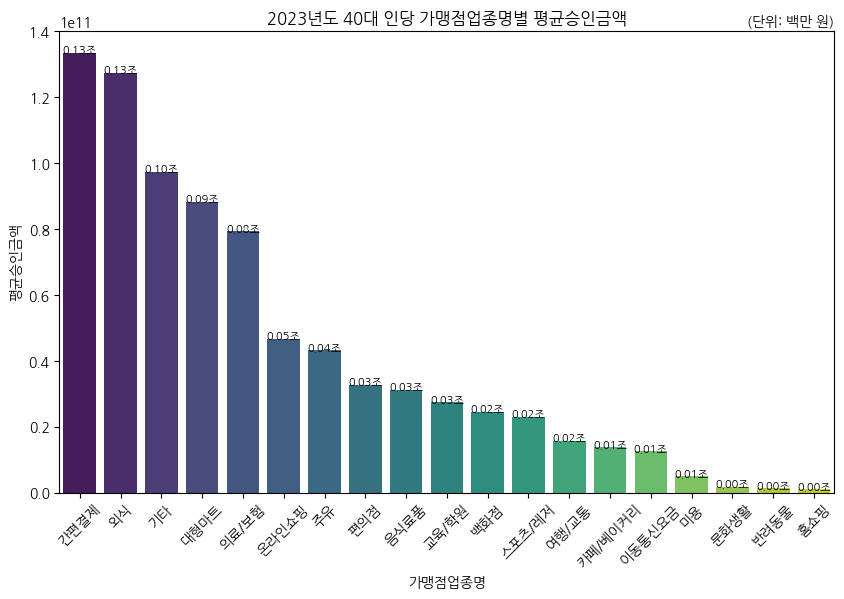

In [87]:
table_avg_2(cc_23_40_r, "고객ID", "가맹점업종명", "승인금액", "2023", "40대")

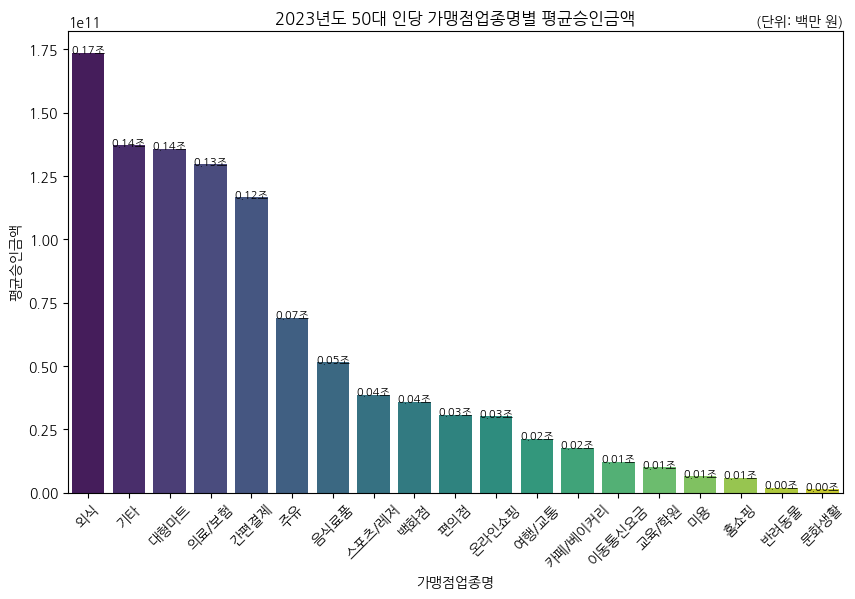

In [89]:
table_avg_2(cc_23_50_r, "고객ID", "가맹점업종명", "승인금액", "2023", "50대")

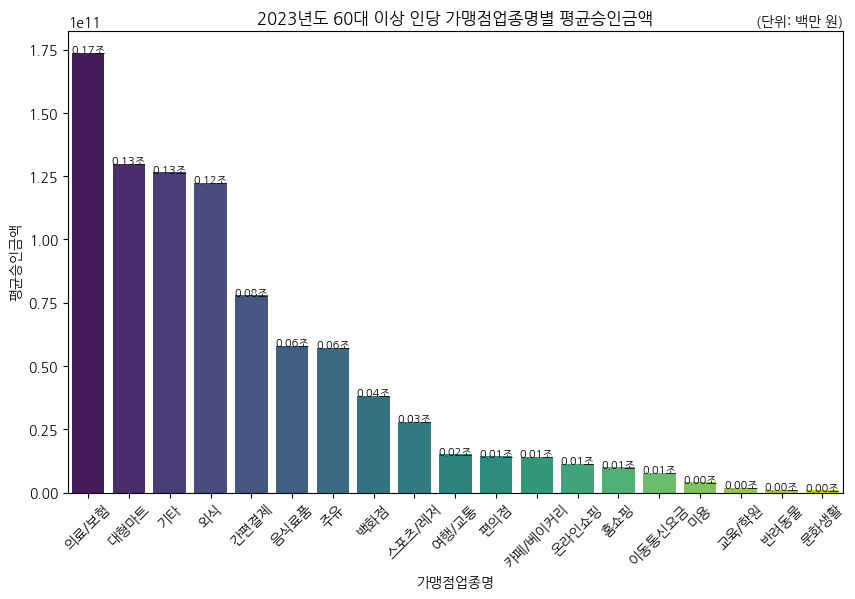

In [90]:
table_avg_2(cc_23_60_r, "고객ID", "가맹점업종명", "승인금액", "2023", "60대 이상")

## 대분류별

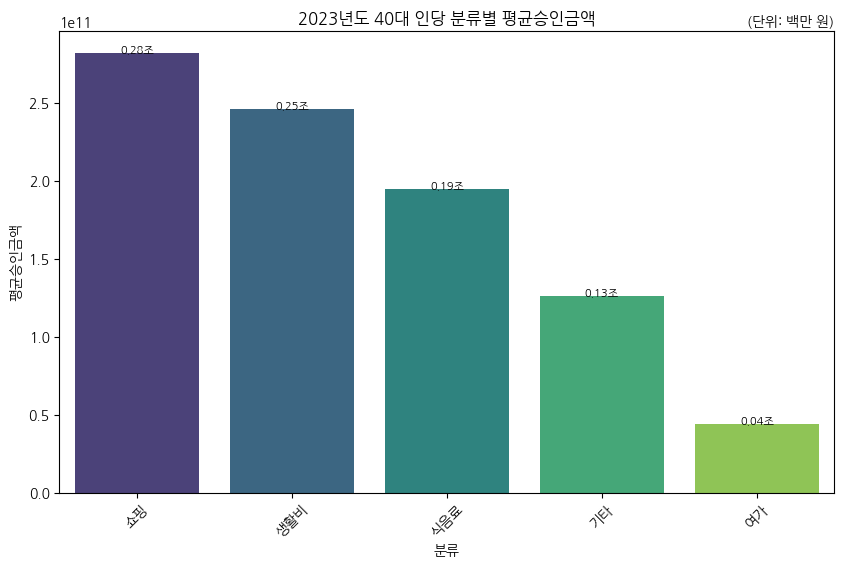

In [91]:
table_avg_2(cc_23_40_r, "고객ID", "분류", "승인금액", "2023", "40대")

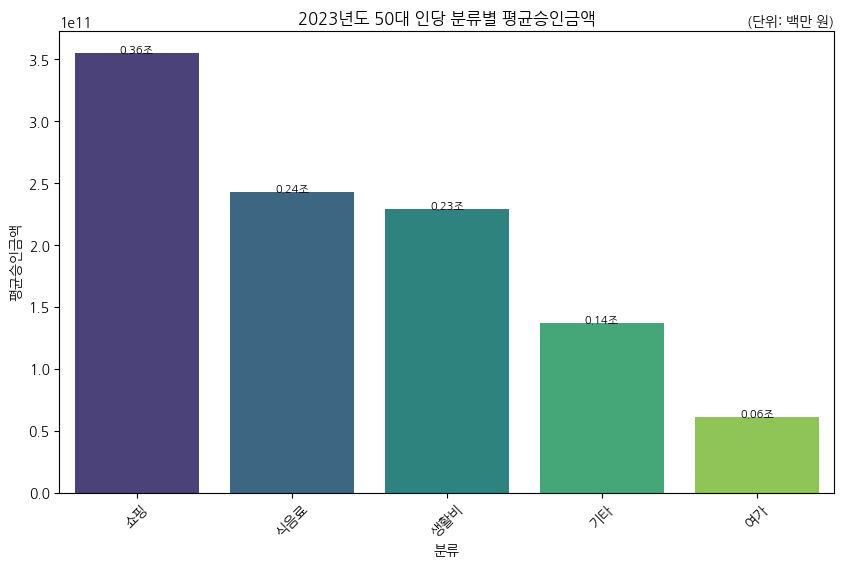

In [93]:
table_avg_2(cc_23_50_r, "고객ID", "분류", "승인금액", "2023", "50대")

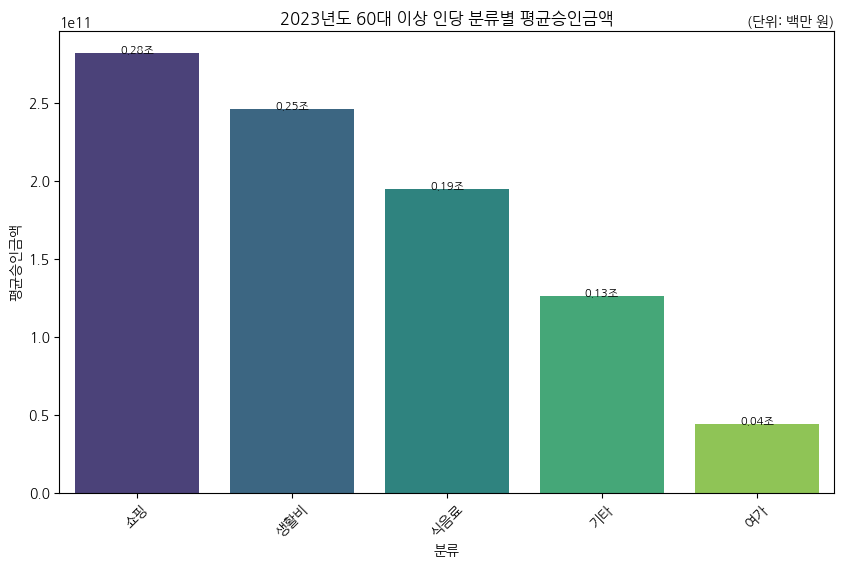

In [95]:
table_avg_2(cc_23_60_r, "고객ID", "분류", "승인금액", "2023", "60대 이상")

## 세대별 비교

In [42]:
cc_23_40_r.head()

,고객ID,거래년월,가맹점업종명,가맹점_광역시도,가맹점_시군구,승인건수,승인금액,분류
0,9997288918,202312,기타,서울특별시,중구,5번이하,9483,기타
1,9997288918,202312,대형마트,경상북도,경산시,5번이하,31139,쇼핑
2,9997288918,202312,음식료품,경상남도,김해시,5번이하,31013,식음료
3,9997288918,202312,편의점,경상북도,김천시,5번이하,32098,쇼핑
4,9997288918,202312,외식,경상북도,김천시,5번이하,20945,식음료


# EDA 4 | 연령별 비교 bar plot

## 승인금액 합계

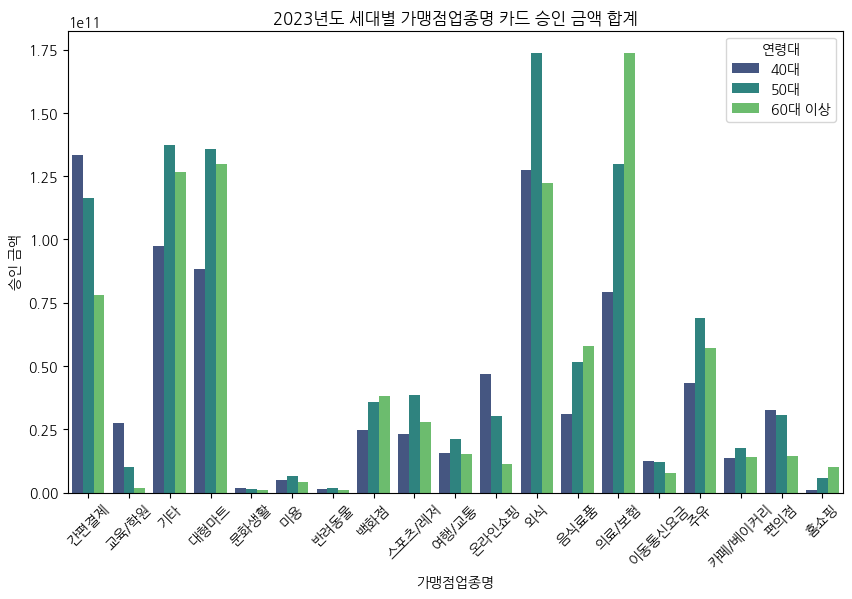

In [51]:
compare_generation_spending(cc_23_40_r, cc_23_50_r, cc_23_60_r, "가맹점업종명", "승인금액", "2023")

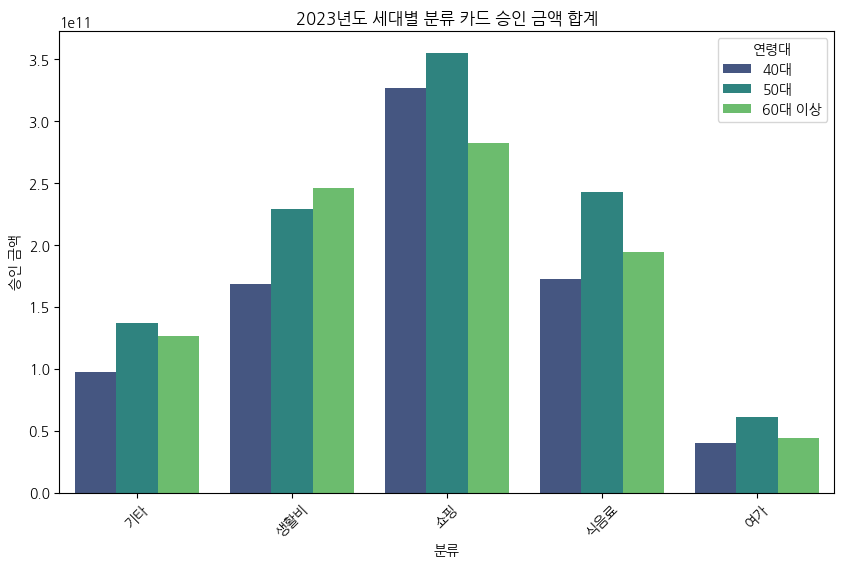

In [53]:
compare_generation_spending(cc_23_40_r, cc_23_50_r, cc_23_60_r, "분류", "승인금액", "2023")

## 인당 평균승인금액

### 가맹점업종명

#### (1) 먼저 인당 평균 승인금액 계산

In [63]:
# 위에 수행되어 있어 여기는 주석 처리
#cc_23_40_g = table_avg_2(cc_23_40_r, "고객ID", "가맹점업종명", "승인금액", "40대")
#cc_23_50_g = table_avg_2(cc_23_50_r, "고객ID", "가맹점업종명", "승인금액", "50대")
#cc_23_60_g = table_avg_2(cc_23_60_r, "고객ID", "가맹점업종명", "승인금액", "60대 이상")

#### (2) 연령별 비교 barplot

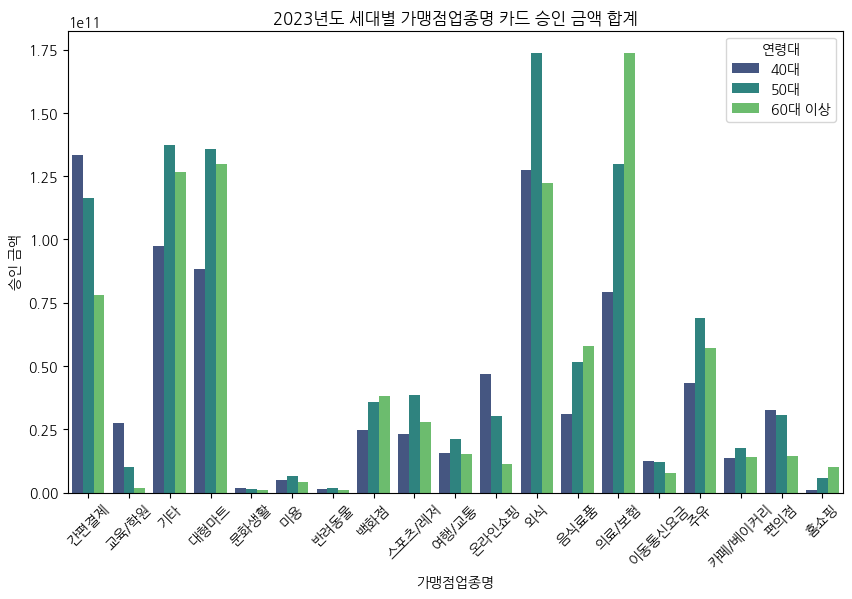

In [73]:
compare_generation_spending(cc_23_40_g, cc_23_50_g, cc_23_60_g, "가맹점업종명", "승인금액", "2023")

### 대분류

In [74]:
cc_23_40_gg = table_avg_2(cc_23_40_r, "고객ID", "분류", "승인금액", "40대")
cc_23_50_gg = table_avg_2(cc_23_50_r, "고객ID", "분류", "승인금액", "50대")
cc_23_60_gg = table_avg_2(cc_23_60_r, "고객ID", "분류", "승인금액", "60대 이상")

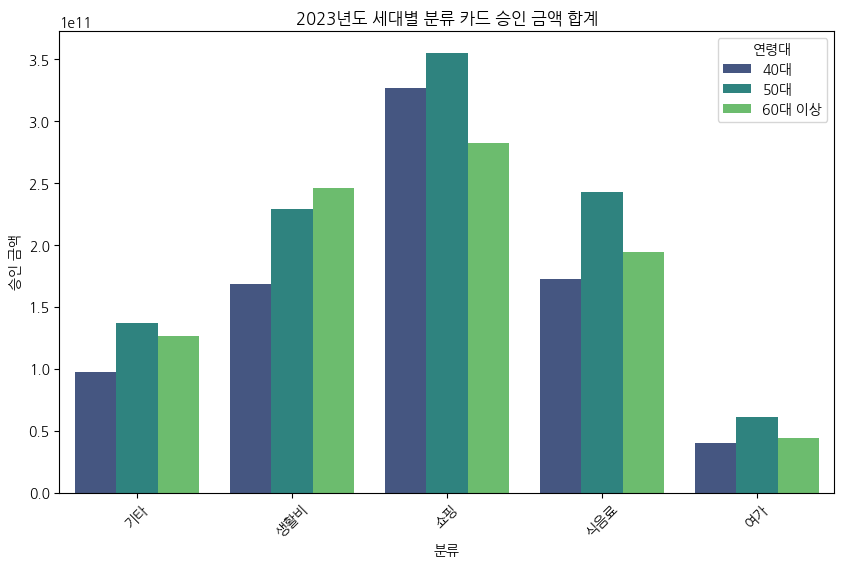

In [75]:
compare_generation_spending(cc_23_40_gg, cc_23_50_gg, cc_23_60_gg, "분류", "승인금액", "2023")

# EDA 5 | 대분류별 box plot

In [70]:
cc_23_40_r['분류'].unique()

array(['기타', '쇼핑', '식음료', '생활비', '여가'], dtype=object)

## 쇼핑

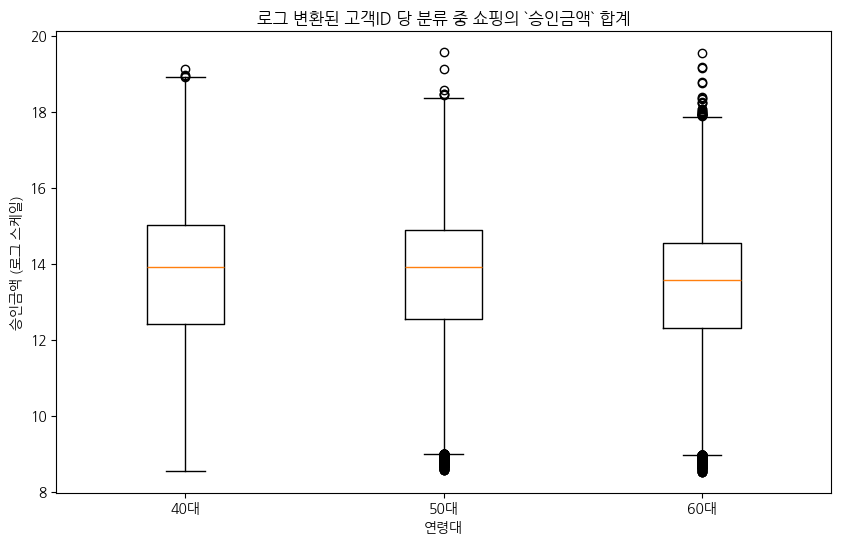

In [75]:
boxplot_log([cc_23_40_r, cc_23_50_r, cc_23_60_r], category='분류', target='승인금액', feature='쇼핑')
# 그림 내보내기 : plt.savefig("로그변환쇼핑boxplot.png", format="png", dpi=300)

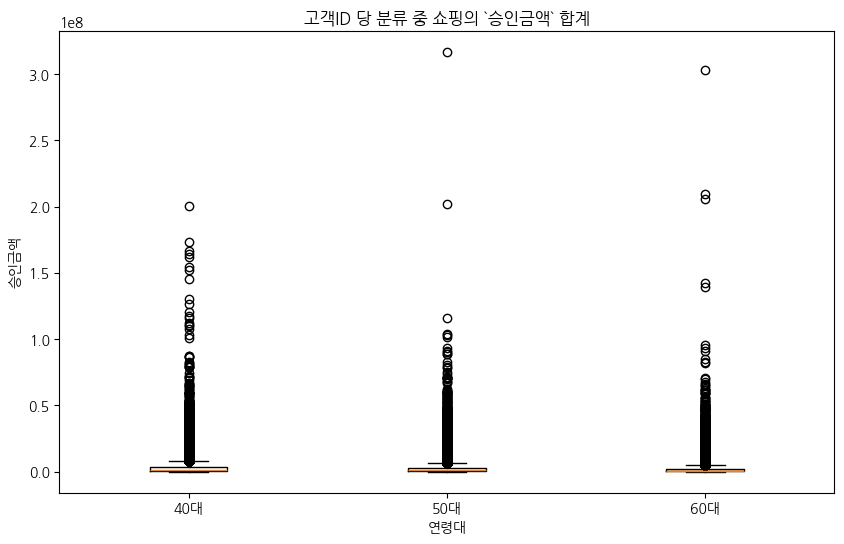

In [65]:
boxplot_log([cc_23_40_r, cc_23_50_r, cc_23_60_r], category='분류', target='승인금액', feature='쇼핑', log=False)

## 생활비

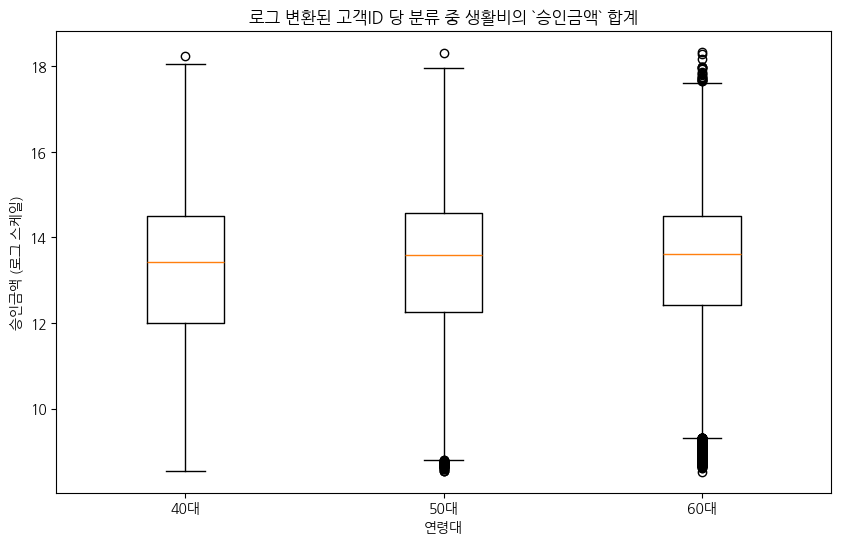

In [66]:
boxplot_log([cc_23_40_r, cc_23_50_r, cc_23_60_r], category='분류', target='승인금액', feature='생활비')

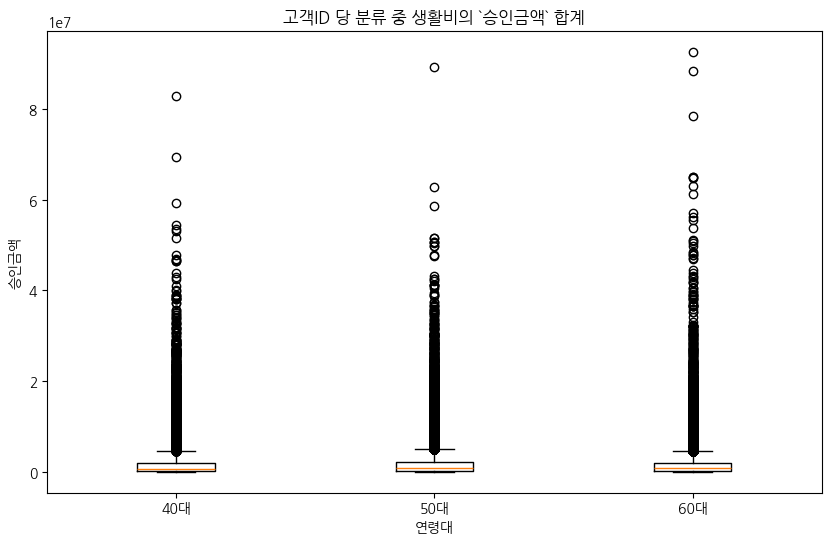

In [67]:
boxplot_log([cc_23_40_r, cc_23_50_r, cc_23_60_r], category='분류', target='승인금액', feature='생활비', log=False)

## 여가

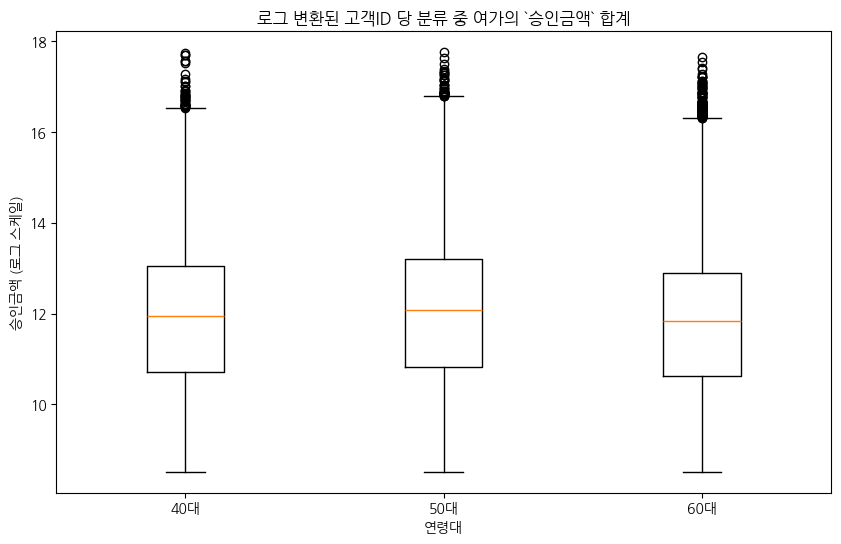

In [68]:
boxplot_log([cc_23_40_r, cc_23_50_r, cc_23_60_r], category='분류', target='승인금액', feature='여가')

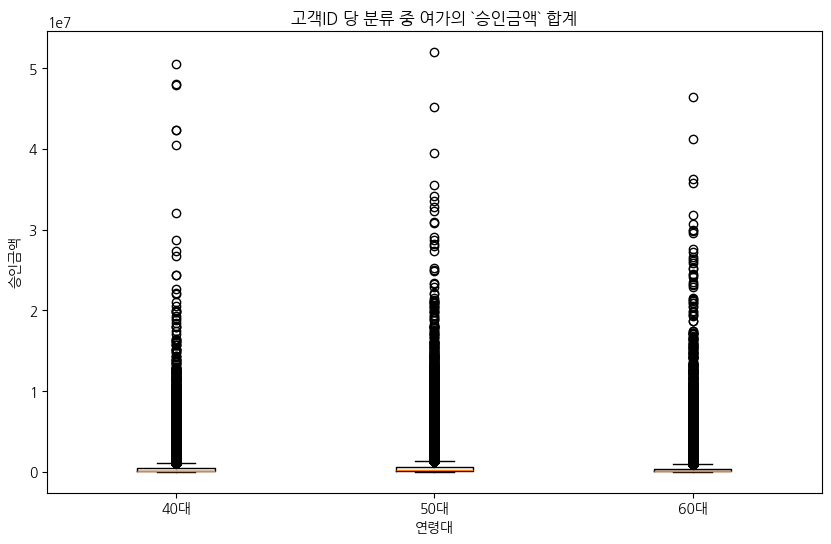

In [69]:
boxplot_log([cc_23_40_r, cc_23_50_r, cc_23_60_r], category='분류', target='승인금액', feature='여가', log=False)

## 식음료

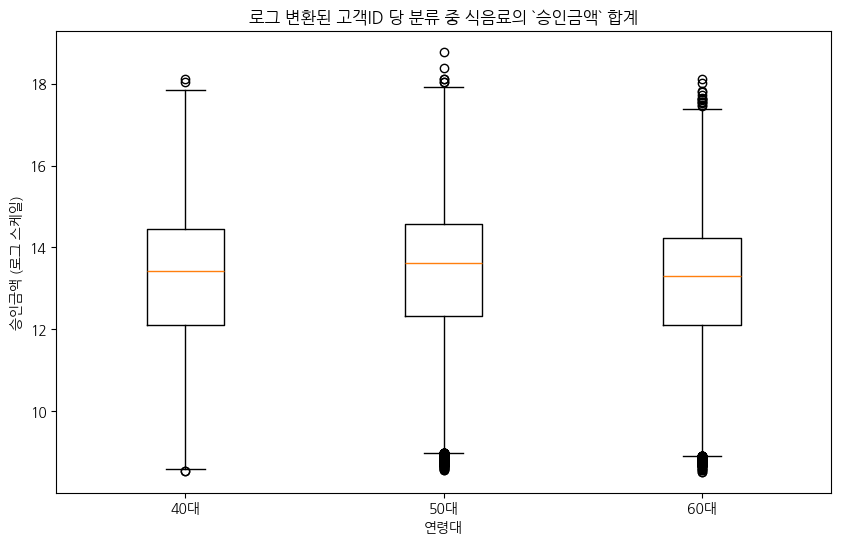

In [71]:
boxplot_log([cc_23_40_r, cc_23_50_r, cc_23_60_r], category='분류', target='승인금액', feature='식음료')

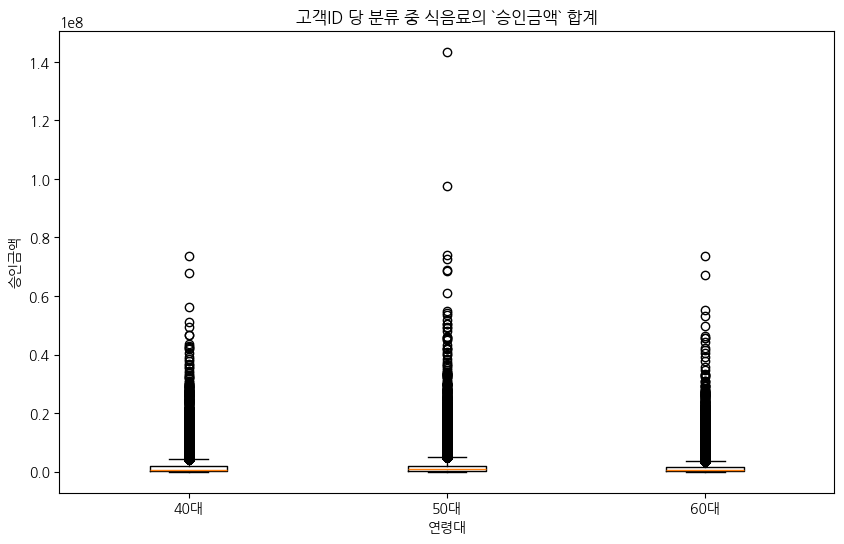

In [72]:
boxplot_log([cc_23_40_r, cc_23_50_r, cc_23_60_r], category='분류', target='승인금액', feature='식음료', log=False)

## 기타

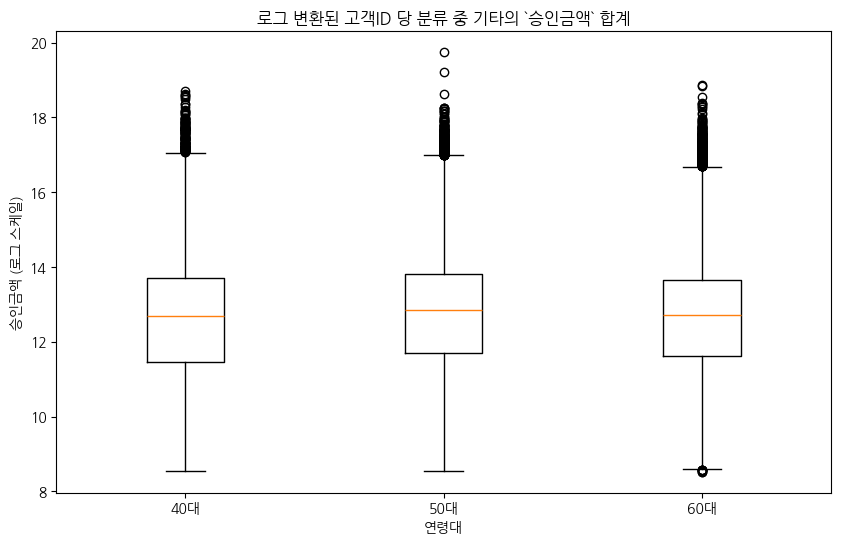

In [73]:
boxplot_log([cc_23_40_r, cc_23_50_r, cc_23_60_r], category='분류', target='승인금액', feature='기타')

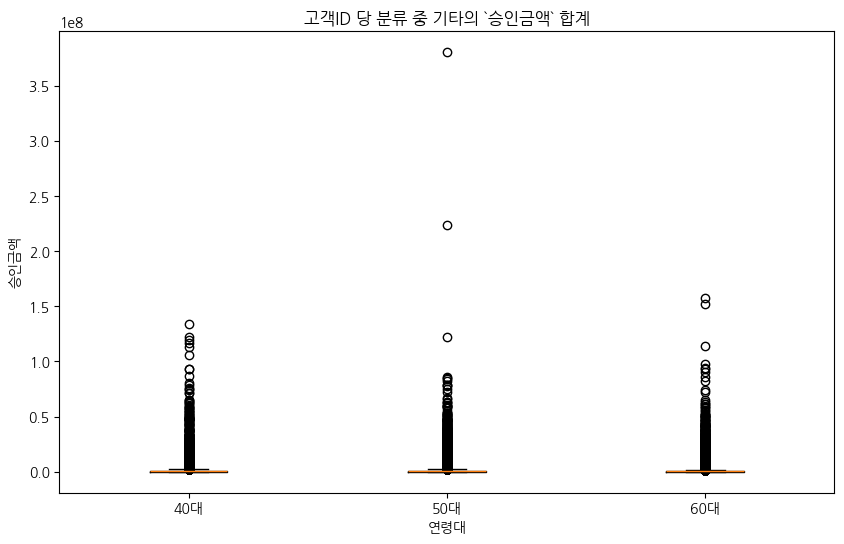

In [74]:
boxplot_log([cc_23_40_r, cc_23_50_r, cc_23_60_r], category='분류', target='승인금액', feature='기타', log=False)